# Carga de Datos y Conversión de Nombres

In [2]:
# Cargar datasets
df_Noel = pd.read_excel('Noel_Test.xlsx')
df_Varma = pd.read_csv('Varma.csv',
                       sep = ',',
                       header = None,
                       skiprows = 1,
                       names = ['ds', 'y', 'unique_id'],
                       quoting = csv.QUOTE_NONE,
                       engine = 'python'
                       )

In [3]:
# 2) Limpiar comillas sobrantes
df_Varma['ds']        = df_Varma['ds'].str.strip('"')
df_Varma['unique_id'] = df_Varma['unique_id'].str.strip('"')

In [4]:
# 3) Convertir tipos
df_Varma['ds'] = pd.to_datetime(df_Varma['ds'], format = '%Y%m')    # datetime64[ns]
df_Varma['y']  = pd.to_numeric(df_Varma['y'],   errors = 'coerce').fillna(0)  # float

In [5]:
# Convertir columnas 'PRODUCT_CODE', 'CODE_MONTH' y 'TOTAL_AMOUNT':
df_Noel['ds'] = pd.to_datetime(df_Noel['CODE_MONTH'].astype(str), format = '%Y%m')

df_Noel = df_Noel.rename(columns = {'PRODUCT_CODE': 'unique_id',
                                    'TOTAL_AMOUNT': 'y'})

In [6]:
# Cambiar el tipo de 'unique_id' a objeto (object)
df_Noel['unique_id'] = df_Noel['unique_id'].astype('object')

# Cambiar el tipo de 'y' a float64
df_Noel['y'] = df_Noel['y'].astype('float64')

# Eliminar la columna 'CODE_MONTH'
df_Noel = df_Noel.drop(columns = ['CODE_MONTH'])

In [7]:
# Reordenación de las columnas de los dataframes
df_Noel = df_Noel[['unique_id', 'ds', 'y']]
df_Varma = df_Varma[['unique_id', 'ds', 'y']]

# Ordenar filas ascedentemente primero por 'ds' y luego por 'unique_id'
df_Noel = df_Noel.sort_values(by = ['unique_id', 'ds']).reset_index(drop = True)
df_Varma = df_Varma.sort_values(by = ['unique_id', 'ds']).reset_index(drop = True)

# Breve descripción de las series

In [8]:
def summarize_ts(df, ds_col = 'ds', id_col = 'unique_id', target_col = 'y'):
    # Asegurarse de que ds es datetime
    df[ds_col] = pd.to_datetime(df[ds_col])

    # 1) Estadísticas descriptivas globales para la columna target_col
    desc_global = df[target_col].describe()

    # 2) Número de series diferentes
    n_series = df[id_col].nunique()

    # 3) Fechas globales
    ds_min_global = df[ds_col].min()
    ds_max_global = df[ds_col].max()

    # 4) Estadísticas por serie usando Named Aggregation
    series_summary = (
        df
        .groupby(id_col)
        .agg(
            series_length     = (target_col, 'size'),
            mean              = (target_col, 'mean'),
            median            = (target_col, 'median'),
            minimum           = (target_col, 'min'),
            q25               = (target_col, lambda x: x.quantile(0.25)),
            q75               = (target_col, lambda x: x.quantile(0.75)),
            maximum           = (target_col, 'max'),
            first_date        = (ds_col, 'min'),
            last_date         = (ds_col, 'max')
        )
        .reset_index()
        # opcional: ordenar columnas
        [['unique_id','series_length','first_date','last_date',
          'mean','median','minimum','q25','q75','maximum']]
    )

    # Imprimir resumen global
    print("=== Estadísticas globales de", target_col, "===")
    print(desc_global.to_frame().T, end="\n\n")
    print(f"Número de series ({id_col} distintos): {n_series}")
    print(f"Fecha mínima global ({ds_col}): {ds_min_global.date()}")
    print(f"Fecha máxima global ({ds_col}): {ds_max_global.date()}", end="\n\n")

    print("=== Estadísticas por serie ===")
    display(series_summary)  # en Jupyter; en script podría ser print(series_summary)

    # Devolver para uso programático
    return {
        'global_stats': desc_global,
        'n_series': n_series,
        'ds_min_global': ds_min_global,
        'ds_max_global': ds_max_global,
        'series_summary': series_summary
    }

In [9]:
summary_Noel = summarize_ts(df_Noel)

=== Estadísticas globales de y ===
    count         mean           std  min    25%     50%      75%       max
y  3389.0  13765.90675  28856.218909  0.0  570.0  3328.0  12672.0  295800.0

Número de series (unique_id distintos): 326
Fecha mínima global (ds): 2019-01-01
Fecha máxima global (ds): 2025-04-01

=== Estadísticas por serie ===


,unique_id,series_length,first_date,last_date,mean,median,minimum,q25,q75,maximum
0,12193,47,2019-01-01,2025-03-01,17412.852553,16943.36,8906.55,16515.62,17388.80,34481.200
1,12235,37,2019-01-01,2025-04-01,48.358649,31.73,3.92,5.19,42.00,382.060
2,12383,9,2019-04-01,2024-08-01,268.277111,157.16,59.57,90.42,297.79,864.864
3,12613,14,2019-02-01,2024-08-01,2303.982143,203.00,84.00,203.00,1921.25,10552.500
4,12806,17,2020-04-01,2025-04-01,20653.176471,11648.00,6656.00,9984.00,29952.00,59904.000
...,...,...,...,...,...,...,...,...,...,...
321,41142,5,2024-08-01,2024-12-01,57.600000,56.00,40.00,48.00,64.00,80.000
322,41143,5,2024-08-01,2024-12-01,58.400000,64.00,32.00,48.00,68.00,80.000
323,41144,5,2024-08-01,2024-12-01,60.000000,56.00,48.00,52.00,64.00,80.000
324,41150,3,2024-11-01,2025-01-01,705.666667,242.00,184.00,213.00,966.50,1691.000


In [10]:
summary_Varma = summarize_ts(df_Varma)

=== Estadísticas globales de y ===
    count        mean          std     min  25%  50%   75%      max
y  2201.0  260.447751  3184.908318 -1350.0  1.0  6.0  30.0  96000.0

Número de series (unique_id distintos): 365
Fecha mínima global (ds): 2023-01-01
Fecha máxima global (ds): 2025-06-01

=== Estadísticas por serie ===


,unique_id,series_length,first_date,last_date,mean,median,minimum,q25,q75,maximum
0,0102300062,12,2023-01-01,2025-05-01,14.333333,8.5,1.0,3.00,30.00,30.0
1,0102300068,7,2024-06-01,2025-04-01,59.000000,54.0,18.0,39.00,84.50,94.0
2,0102300535,12,2023-03-01,2025-04-01,39.833333,36.0,2.0,16.50,55.75,96.0
3,0102300537,6,2024-08-01,2025-05-01,78.000000,57.0,12.0,24.00,126.00,180.0
4,0102300548,3,2024-09-01,2025-05-01,400.000000,480.0,120.0,300.00,540.00,600.0
...,...,...,...,...,...,...,...,...,...,...
360,0518001050,1,2024-12-01,2024-12-01,509.000000,509.0,509.0,509.00,509.00,509.0
361,0520400026,5,2024-09-01,2025-05-01,4.200000,2.0,0.0,1.00,4.00,14.0
362,0520400027,6,2024-10-01,2025-05-01,4.833333,4.5,0.0,2.25,7.50,10.0
363,0520400030,6,2024-09-01,2025-05-01,1.833333,1.5,0.0,0.25,2.00,6.0


Ahora se procede a rellenar las series de ambos dataframes con registros virtuales con demanda igual a cero para aquellas fechas o filas que faltan, de manera que así, cada serie (unique_id), tenga registros periódicos desde la fecha inicial a la fecha final de cada serie, aunque sea demanda cero.

También se añaden registros con demanda cero a todas aquellas series cuya fecha final sea inferior a la fecha final global del dataset, de manera que todas las series acaben en el mismo instante de tiempo, independientemente de su fecha de inicio.

In [11]:
# 1. Calcula la fecha máxima global en ds.
# 2. Para cada unique_id, genera todas las fechas mensuales desde su fecha mínima hasta esa fecha global.
# 3. Rellena los valores faltantes de 'y' con 0.0
# 4. Devuelve un DataFrame ordenado por 'unique_id' y luego por 'ds'.

def fill_missing_months(df, ds_col = 'ds', id_col = 'unique_id', target_col = 'y'):
    # Copia y asegura tipos
    df = df.copy()
    df[ds_col] = pd.to_datetime(df[ds_col])
    df[id_col] = df[id_col].astype('object')
    df[target_col] = df[target_col].astype('float64')

    # Fecha Global Máxima
    global_max_date = df[ds_col].max()

    filled = []
    # Iteramos por serie
    for uid, grp in df.groupby(id_col, sort = False):
        start = grp[ds_col].min()
        # Generar rango mensual desde el inicio de la serie hasta global_max
        all_months = pd.date_range(start = start, end = global_max_date, freq = 'MS')

        # DataFrame base con todas las fechas
        tmp = pd.DataFrame({ds_col: all_months})
        tmp[id_col] = uid

        # Merge para traer los 'y' originales (si existen)
        tmp = tmp.merge(grp[[ds_col, target_col]], on = ds_col, how = 'left')

        # Imputar NaN con 0.0
        tmp[target_col] = tmp[target_col].fillna(0.0)

        filled.append(tmp)
    
    # Concatenar todo
    df_filled = pd.concat(filled, ignore_index = True)

    # Renombrar columnas y filas
    df_filled = df_filled[[id_col, ds_col, target_col]]
    df_filled = (df_filled.sort_values(by = [id_col, ds_col]).reset_index(drop = True))

    # Asegurar tipos finales
    df_filled[id_col] = df_filled[id_col].astype('object')
    df_filled[target_col] = df_filled[target_col].astype('float64')

    return df_filled

In [12]:
df_Noel_filled = fill_missing_months(df_Noel)
df_Varma_filled = fill_missing_months(df_Varma)

# Verificar
print(df_Noel_filled.head(15))
print(df_Noel_filled.dtypes)

print(df_Varma_filled.head(15))
print(df_Varma_filled.dtypes)

   unique_id         ds         y
0      12193 2019-01-01  17148.81
1      12193 2019-02-01  18449.09
2      12193 2019-03-01  16504.88
3      12193 2019-04-01  16862.63
4      12193 2019-05-01      0.00
5      12193 2019-06-01  16410.46
6      12193 2019-07-01      0.00
7      12193 2019-08-01  17314.59
8      12193 2019-09-01  17618.34
9      12193 2019-10-01  16943.36
10     12193 2019-11-01  32451.99
11     12193 2019-12-01      0.00
12     12193 2020-01-01  15459.36
13     12193 2020-02-01  15728.09
14     12193 2020-03-01      0.00
unique_id            object
ds           datetime64[ns]
y                   float64
dtype: object
     unique_id         ds     y
0   0102300062 2023-01-01   3.0
1   0102300062 2023-02-01   1.0
2   0102300062 2023-03-01   3.0
3   0102300062 2023-04-01   0.0
4   0102300062 2023-05-01   3.0
5   0102300062 2023-06-01  14.0
6   0102300062 2023-07-01  30.0
7   0102300062 2023-08-01   0.0
8   0102300062 2023-09-01   0.0
9   0102300062 2023-10-01   0.0
10  01

# Imputación de valores negativos a cero

In [13]:
# Para df_Noel_filled y df_Varma_filled, antes de caracterizar:
for df in (df_Noel_filled, df_Varma_filled):
    # Opción A: usando clip
    df['y'] = df['y'].clip(lower = 0.0)

    # Opción B: usando loc
    # df.loc[df['y'] < 0, 'y'] = 0.0

# Con esto, cualquier y < 0 pasará a valer 0.0 y el describe() nunca mostrará medias negativas ni mínimos por debajo de cero.

In [14]:
summary_Noel_filled = summarize_ts(df_Noel_filled)
summary_Varma_filled = summarize_ts(df_Varma_filled)

=== Estadísticas globales de y ===
     count         mean           std  min  25%  50%        75%       max
y  12323.0  3785.819847  16332.057029  0.0  0.0  0.0  66.132044  295800.0

Número de series (unique_id distintos): 326
Fecha mínima global (ds): 2019-01-01
Fecha máxima global (ds): 2025-04-01

=== Estadísticas por serie ===


,unique_id,series_length,first_date,last_date,mean,median,minimum,q25,q75,maximum
0,12193,76,2019-01-01,2025-04-01,10768.474605,16364.07,0.0,0.0,17126.8125,34481.200
1,12235,76,2019-01-01,2025-04-01,23.543026,0.00,0.0,0.0,27.6200,382.060
2,12383,73,2019-04-01,2025-04-01,33.075260,0.00,0.0,0.0,0.0000,864.864
3,12613,75,2019-02-01,2025-04-01,430.076667,0.00,0.0,0.0,0.0000,10552.500
4,12806,61,2020-04-01,2025-04-01,5755.803279,0.00,0.0,0.0,6656.0000,59904.000
...,...,...,...,...,...,...,...,...,...,...
321,41142,9,2024-08-01,2025-04-01,32.000000,40.00,0.0,0.0,56.0000,80.000
322,41143,9,2024-08-01,2025-04-01,32.444444,32.00,0.0,0.0,64.0000,80.000
323,41144,9,2024-08-01,2025-04-01,33.333333,48.00,0.0,0.0,56.0000,80.000
324,41150,6,2024-11-01,2025-04-01,352.833333,92.00,0.0,0.0,227.5000,1691.000


=== Estadísticas globales de y ===
    count      mean          std  min  25%  50%  75%      max
y  7260.0  79.20466  1757.352604  0.0  0.0  0.0  0.0  96000.0

Número de series (unique_id distintos): 365
Fecha mínima global (ds): 2023-01-01
Fecha máxima global (ds): 2025-06-01

=== Estadísticas por serie ===


,unique_id,series_length,first_date,last_date,mean,median,minimum,q25,q75,maximum
0,0102300062,30,2023-01-01,2025-06-01,5.733333,0.0,0.0,0.0,3.00,30.0
1,0102300068,13,2024-06-01,2025-06-01,31.769231,18.0,0.0,0.0,54.00,94.0
2,0102300535,28,2023-03-01,2025-06-01,17.071429,0.0,0.0,0.0,27.00,96.0
3,0102300537,11,2024-08-01,2025-06-01,42.545455,12.0,0.0,0.0,57.00,180.0
4,0102300548,10,2024-09-01,2025-06-01,120.000000,0.0,0.0,0.0,90.00,600.0
...,...,...,...,...,...,...,...,...,...,...
360,0518001050,7,2024-12-01,2025-06-01,72.714286,0.0,0.0,0.0,0.00,509.0
361,0520400026,10,2024-09-01,2025-06-01,2.100000,0.0,0.0,0.0,1.75,14.0
362,0520400027,9,2024-10-01,2025-06-01,3.222222,2.0,0.0,0.0,6.00,10.0
363,0520400030,10,2024-09-01,2025-06-01,1.100000,0.0,0.0,0.0,1.75,6.0


# Clasificación de las Series en función de Intermitencia y Variabilidad

In [16]:
print(df_Noel_filled['unique_id'].nunique())  # → debería imprimir 326
print(df_Varma_filled['unique_id'].nunique()) # → debería imprimir 365

326
365


In [17]:
# 1) Definimos ADI y CV2
def calculate_adi(ts: pd.Series) -> float:
    n_tot = len(ts)
    n_nonzero = (ts > 0).sum()
    return n_tot / n_nonzero if n_nonzero > 0 else np.inf

def calculate_cv2(ts: pd.Series) -> float:
    v = ts[ts > 0]
    mu = v.mean()
    sigma = v.std(ddof = 0) # poblacional
    return (sigma / mu)**2 if mu != 0 else np.nan

# 2) Nueva versión de characterize_series usando esas funciones
def characterize_series(df, 
                        ds_col: str = 'ds',
                        id_col: str = 'unique_id',
                        y_col:  str = 'y') -> pd.DataFrame:
    
    # 2.1) ¿Cuántas series tenemos?
    unique_ids = df[id_col].unique()
    print(f"✔️  Encontradas {len(unique_ids)} series distintas (IDs).")

    records = []
    for uid in unique_ids:
        grp = df[df[id_col] == uid]
        ts  = grp.set_index(ds_col)[y_col].sort_index()

        # 2) ADI y CV²
        adi = calculate_adi(ts)
        cv2 = calculate_cv2(ts)

        # 3) Estadísticas descriptivas de y
        desc = ts.describe()  # count, mean, std, min, 25%, 50%, 75%, max

        # 4) Proporción de ceros
        pz = (ts == 0).mean()

        # 5) Categoría final (mismo criterio interno)
        if   (adi >= 1.32 and cv2 <= 0.49): cat = 'Intermittent'
        elif (adi >= 1.32 and cv2 >= 0.49): cat = 'Lumpy'
        elif (adi <= 1.32 and cv2 >= 0.49): cat = 'Erratic'
        else:                               cat = 'Smooth'

        records.append({
            id_col       : uid,
            'mean'       : desc['mean'],
            'std'        : desc['std'],
            'min'        : desc['min'],
            '25%'        : desc['25%'],
            'median'     : desc['50%'],
            '75%'        : desc['75%'],
            'max'        : desc['max'],
            'first_date' : ts.index.min(),
            'last_date'  : ts.index.max(),
            'length'     : len(ts),
            'pZeros'     : pz,
            'ADI'        : adi,
            'CV2'        : cv2,
            'Cat'        : cat
        })

    summary_df = pd.DataFrame.from_records(records)

    # Asegúrate del orden de columnas
    cols = [id_col, 'mean','std','min','25%','median','75%','max',
            'first_date','last_date','length','pZeros','ADI','CV2','Cat']
    return summary_df.loc[:, cols].reset_index(drop = True)
    #      ^-----------------seleccionamos "todas las filas" y luego las columnas cols

# 3) Función para dibujar el scatter plot
def plot_demand_by_category(summary_df):
    # Definimos mapeo categoría → (sigla, color)
    cat_map = {'Intermittent': ('ITS', 'C0'),
               'Smooth':       ('STS', 'C1'),
               'Erratic':      ('ETS', 'C2'),
               'Lumpy':        ('LTS', 'C3')
    }

    fig, ax = plt.subplots(figsize = (10, 8))

    # Scatter por categoría
    for cat, (abbr, color) in cat_map.items():
        df_cat = summary_df[summary_df['Cat'] == cat]
        ax.scatter(df_cat['CV2'], df_cat['ADI'], label = f"{abbr} ({len(df_cat)})", alpha = 0.6, color = color)

    # Líneas de corte (Umbrales)
    ax.axvline(x = 0.49, color = 'red', linewidth = 1.2)
    ax.axhline(y = 1.32, color = 'red', linewidth = 1.2)

    ax.set_xlabel('CV² (Variabilidad Relativa)')
    ax.set_ylabel('ADI (Intermitencia Promedio)')
    ax.set_title('Demand Profile: CV² vs ADI')
    ax.set_xlim(left = -0.1)
    ax.set_ylim(bottom = -0.1)

    ax.legend(title = 'Categoría (n° series)')
    plt.grid(alpha = 0.3)
    plt.tight_layout()
    plt.show()

# 4) Tabla resumen de la clasificación y composición de lo datasets
def category_summary_table(summary_df):
    # Conteo y porcentaje por categoría
    vc = summary_df['Cat'].value_counts().rename('count')
    pct = (vc / vc.sum() * 100).round(1).rename('percent')
    table = pd.concat([vc, pct], axis = 1).reset_index()
    table.columns = ['Cat', 'count', 'percent']

    # Añadir columas de sigla
    siglas = {'Intermittent':'ITS', 'Smooth':'STS', 'Erratic':'ETS', 'Lumpy':'LTS'}
    table['abbr'] = table['Cat'].map(siglas)

    # Reordenar columnas
    return table[['Cat', 'abbr', 'count', 'percent']]

✔️  Encontradas 326 series distintas (IDs).
Noel: (326, 15) → 326 series filas
Tabla resumen de categorías:
         Cat abbr  count  percent
Intermittent  ITS    273     83.7
       Lumpy  LTS     53     16.3

Gráfico de demanda por categoría:


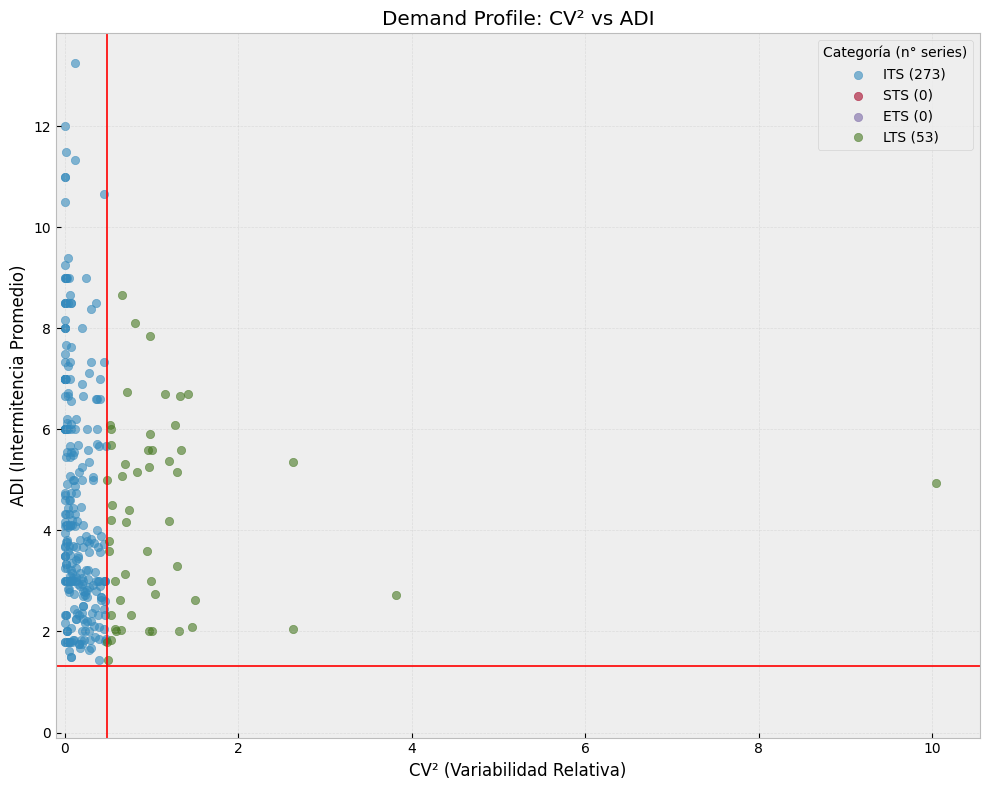

In [18]:
df_Noel_summary  = characterize_series(df_Noel_filled)

print("Noel:", df_Noel_summary.shape, "→ 326 series filas")

# Graficar la tabla resumen
print("Tabla resumen de categorías:")
print(category_summary_table(df_Noel_summary).to_string(index = False))

# Dibuja el scatter
print("\nGráfico de demanda por categoría:")
plot_demand_by_category(df_Noel_summary)

# QUÉ HACE?
# 1. plot_by_category
#     Recorre las cuatro categorías, filtra summary_df y traza un scatter con un color distinto.
#     La leyenda incluye la sigla y el número de series de esa categoría.
#     Dibuja las líneas rojas en CV2=0.49 y ADI=1.32.

# 2. category_summary_table
#     Usa value_counts para contar cuántas series hay de cada Cat.
#     Calcula el porcentaje sobre el total.
#     Mapea cada categoría a su sigla (ITS, STS, ETS, LTS).
#     Devuelve un DataFrame con columnas Cat, abbr, count, percent.

✔️  Encontradas 365 series distintas (IDs).
Varma: (365, 15) → 365 series filas
Tabla resumen de categorías:
         Cat abbr  count  percent
       Lumpy  LTS    181     49.6
Intermittent  ITS    177     48.5
      Smooth  STS      7      1.9

Gráfico de demanda por categoría:


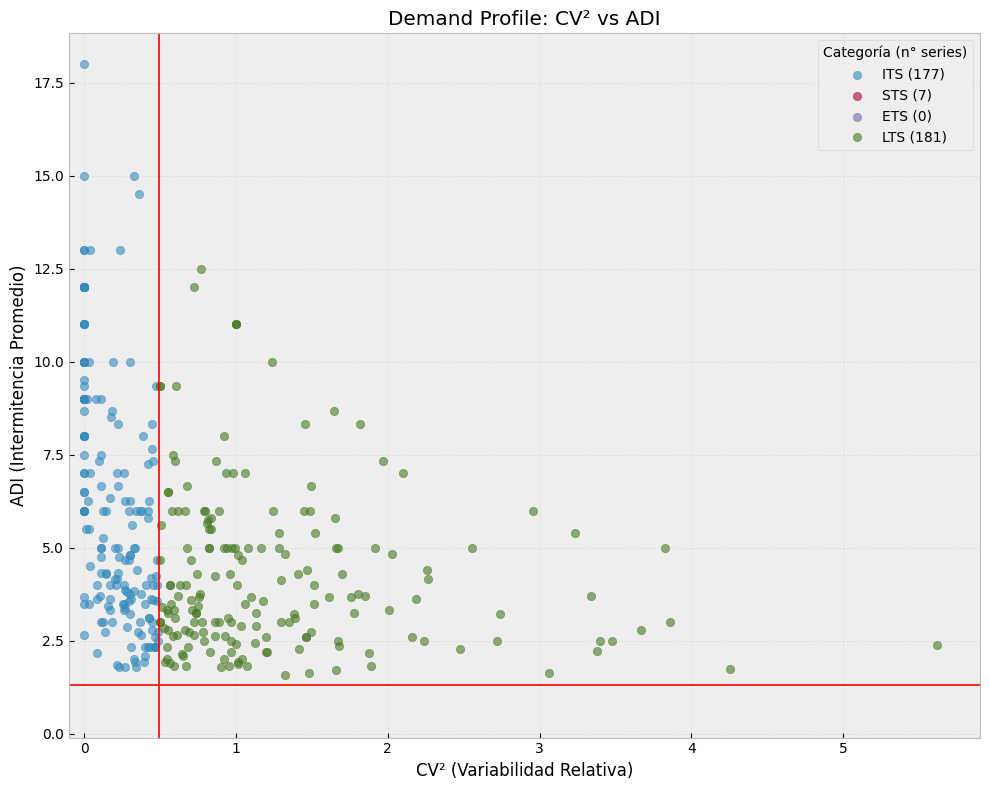

In [19]:
df_Varma_summary = characterize_series(df_Varma_filled)

print("Varma:", df_Varma_summary.shape, "→ 365 series filas")

# Graficar la tabla resumen
print("Tabla resumen de categorías:")
print(category_summary_table(df_Varma_summary).to_string(index = False))

# Dibuja el scatter
print("\nGráfico de demanda por categoría:")
plot_demand_by_category(df_Varma_summary)

In [20]:
# -----------------------------------------------------------
# Ejemplo de uso con tu DataFrame rellenado de Noel:
print("\n→ Resumiendo df_Noel_filled…")
df_Noel_summary = characterize_series(df_Noel_filled)
print("Shape de resumen Noel (filas = series):", df_Noel_summary.shape)
display(df_Noel_summary.head())

# Y lo mismo para Varma:
print("\n→ Resumiendo df_Varma_filled…")
df_Varma_summary = characterize_series(df_Varma_filled)
print("Shape de resumen Varma (filas = series):", df_Varma_summary.shape)
display(df_Varma_summary.head())


→ Resumiendo df_Noel_filled…
✔️  Encontradas 326 series distintas (IDs).
Shape de resumen Noel (filas = series): (326, 15)


,unique_id,mean,std,min,25%,median,75%,max,first_date,last_date,length,pZeros,ADI,CV2,Cat
0,12193,10768.474605,8992.842311,0.0,0.0,16364.07,17126.8125,34481.200,2019-01-01,2025-04-01,76,0.381579,1.617021,0.044037,Intermittent
1,12235,23.543026,60.200086,0.0,0.0,0.00,27.6200,382.060,2019-01-01,2025-04-01,76,0.513158,2.054054,2.628113,Lumpy
2,12383,33.075260,123.402952,0.0,0.0,0.00,0.0000,864.864,2019-04-01,2025-04-01,73,0.876712,8.111111,0.815964,Lumpy
3,12613,430.076667,1861.112132,0.0,0.0,0.00,0.0000,10552.500,2019-02-01,2025-04-01,75,0.813333,5.357143,2.635646,Lumpy
4,12806,5755.803279,12180.865572,0.0,0.0,0.00,6656.0000,59904.000,2020-04-01,2025-04-01,61,0.721311,3.588235,0.506368,Lumpy



→ Resumiendo df_Varma_filled…
✔️  Encontradas 365 series distintas (IDs).
Shape de resumen Varma (filas = series): (365, 15)


,unique_id,mean,std,min,25%,median,75%,max,first_date,last_date,length,pZeros,ADI,CV2,Cat
0,0102300062,5.733333,10.865743,0.0,0.0,0.0,3.0,30.0,2023-01-01,2025-06-01,30,0.600000,2.500000,0.788805,Lumpy
1,0102300068,31.769231,37.013857,0.0,0.0,18.0,54.0,94.0,2024-06-01,2025-06-01,13,0.461538,1.857143,0.213157,Intermittent
2,0102300535,17.071429,28.035597,0.0,0.0,0.0,27.0,96.0,2023-03-01,2025-06-01,28,0.571429,2.333333,0.543145,Lumpy
3,0102300537,42.545455,63.975564,0.0,0.0,12.0,57.0,180.0,2024-08-01,2025-06-01,11,0.454545,1.833333,0.666667,Lumpy
4,0102300548,120.000000,226.274170,0.0,0.0,0.0,90.0,600.0,2024-09-01,2025-06-01,10,0.700000,3.333333,0.260000,Intermittent


In [21]:
# Uso de Clasificación
df_Noel_summary = characterize_series(df_Noel_filled)
df_Varma_summary = characterize_series(df_Varma_filled)

✔️  Encontradas 326 series distintas (IDs).
✔️  Encontradas 365 series distintas (IDs).


In [22]:
# Vemos los primeros registros
print(df_Noel_summary.head())

   unique_id          mean           std  min  25%    median         75%  \
0      12193  10768.474605   8992.842311  0.0  0.0  16364.07  17126.8125   
1      12235     23.543026     60.200086  0.0  0.0      0.00     27.6200   
2      12383     33.075260    123.402952  0.0  0.0      0.00      0.0000   
3      12613    430.076667   1861.112132  0.0  0.0      0.00      0.0000   
4      12806   5755.803279  12180.865572  0.0  0.0      0.00   6656.0000   

         max first_date  last_date  length    pZeros       ADI       CV2  \
0  34481.200 2019-01-01 2025-04-01      76  0.381579  1.617021  0.044037   
1    382.060 2019-01-01 2025-04-01      76  0.513158  2.054054  2.628113   
2    864.864 2019-04-01 2025-04-01      73  0.876712  8.111111  0.815964   
3  10552.500 2019-02-01 2025-04-01      75  0.813333  5.357143  2.635646   
4  59904.000 2020-04-01 2025-04-01      61  0.721311  3.588235  0.506368   

            Cat  
0  Intermittent  
1         Lumpy  
2         Lumpy  
3         Lump

In [23]:
# PIVOT "WIDE" OPCIONAL PARA ANÁLISIS Y MODELADO
df_Noel_pivoted = df_Noel_filled.pivot(index = 'ds', columns = 'unique_id', values = 'y')
df_Varma_pivoted = df_Varma_filled.pivot(index = 'ds', columns = 'unique_id', values = 'y')

# Clasificación de Series en función de Utilidad

Vamos a definir la clasificación con base en:
1. 'Obsoleta': últimos 12 valores de la serie son 0.
2. 'Insuficiente': longitud total de la serie (length) < 12.
3. 'NoApta': solo hay 2 o más valores distintos de 0.

In [24]:
def clasificar_estado_series(df, id_col = 'unique_id', ds_col = 'ds', y_col = 'y'):
    estado_series = {}

    for uid, grupo in df.groupby(id_col):
        serie = grupo.sort_values(ds_col)[y_col].values

        # Criterio 1: Obsoleta -> últimos 12 valores == 0
        if len(serie) >= 12 and np.all(serie[-12:] == 0):
            estado = 'Obsoleta'

        # Criterio 2: Insuficiente -> menos de 12 meses
        elif len(serie) < 12:
            estado = 'Insuficiente'
        
        # Cirterio 3: NoApta -> 2 o menso valores distintos de 0
        elif np.count_nonzero(serie) <= 2:
            estado = 'NoApta'

        else:
            estado = 'Valida' # No cumple ningún criterio de descarte.
        
        estado_series[uid] = estado
    
    return pd.DataFrame.from_dict(estado_series, orient='index', columns = ['Estado']).reset_index().rename(columns = {'index': id_col})

In [25]:
# Aplicar a los datasets
estado_Noel  = clasificar_estado_series(df_Noel_filled)
estado_Varma = clasificar_estado_series(df_Varma_filled)

# Unir con los resúmenes
df_Noel_summary = df_Noel_summary.merge(estado_Noel, on = 'unique_id')
df_Varma_summary = df_Varma_summary.merge(estado_Varma, on = 'unique_id')

# Visualizar conteo de estados
print('Conteo de estados en Noel:')
print(df_Noel_summary['Estado'].value_counts())

print('\n Conteo de estados en Varma:')
print(df_Varma_summary['Estado'].value_counts())

Conteo de estados en Noel:
Estado
Valida          228
Insuficiente     81
NoApta           17
Name: count, dtype: int64

 Conteo de estados en Varma:
Estado
Valida          241
Insuficiente     79
NoApta           39
Obsoleta          6
Name: count, dtype: int64


# Clasificación según umbrales y capacidad de pronóstico según histórico

En esta sección se pretende:
1. Definir los umbrales mínimos de longitud de serie como 3 x H.
2. Añadir cinco flags booleanos can_h1, ..., can_h12.
3. Crear un DataFrame para cada combinación de categoría (ITS, STS, ETS, LTS) y horizonte, con nombres como, por ejemplo, df_Noel_{SIGLA}_h{H}.

El siguiente código:
- Umbrales: asume que para predecir H meses necesitas al menos 3H registros de histórico.
- Flags can_hX: marcan True/False si la serie cumple ese mínimo.
- Variables dinámicas df_Noel_ITS_h1, ..., df_Noel_LTS_h12: contienen solo las filas de df_Noel_filled cuyas series pertenecen a la categoría y cumplen el flag.
- El bucle final imprime cuántas series (unique_id) sobrevivieron al filtro en cada combinación.

In [26]:
def generate_horizon_dataframes(df_summary, df_filled, prefix, 
                                horizons = (1, 3, 6, 9, 12),
                                min_mult = 3):
    """
    Para cualquier df_summary y df_filled con columnas:
        - df_summary: ['unique_id', 'length', 'Cat', ...]
        - df_filled:  ['unique_id', 'ds', 'y']
    Genera:
        - df_summary modificado con flags can_h{H}
        - un dict de DataFrames para cada combinación {prefix}_{SIGLA}_h{H}
    """
    df_summary = df_summary.copy()

    # 1) Definir flags de elegibilidad
    for h in horizons:
        df_summary[f'can_h{h}'] = df_summary['length'] >= (min_mult * h)
    
    # 2) Mapeo de categoría -> siglas
    siglas = {
        'Intermittent': 'ITS',
        'Smooth':       'STS',
        'Erratic':      'ETS',
        'Lumpy':        'LTS'
    }

    # 3) Construir los DataFrames filtrados
    ddff = {}
    for cat, abbr in siglas.items():
        for h in horizons:
            flag = f'can_h{h}'
            valid_ids = df_summary.loc[
                (df_summary['Estado'] == 'Valida') &    # <-- nueovo filtro
                (df_summary['Cat'] == cat) & 
                (df_summary[flag]),
                'unique_id'
            ]
            name = f"{prefix}_{abbr}_h{h}"
            ddff[name] = df_filled[
                df_filled['unique_id'].isin(valid_ids)
            ].copy().sort_values(['unique_id', 'ds']).reset_index(drop = True)
    
    return df_summary, ddff

La idea es generar tantos dataframes como tipos de series temporales intermitentes hallan en cada dataset.
En este caso concreto, tanto en el dataset de Noel como en el de Varma, los subconjuntos más abundantes y de mayor interés son los de las series tipo 'Intermittent' y tipo 'Lumpy', por lo que vamos a crear 4 dataframes (df_Noel_ITS, df_Noel_LTS, df_Varma_ITS, df_Varma_LTS)

In [27]:
# Ejemplo de uso para Noel:
# 1) Generar todo el dict (incluyendo vacíos)
df_Noel_summary, Noel_ddff = generate_horizon_dataframes(df_Noel_summary,
                                                         df_Noel_filled,
                                                         prefix = 'df_Noel')

# 2) Filtrar el dict para quedarte sólo con los que NO estén vacíos
Noel_ddff = {name: df
             for name, df in Noel_ddff.items()
             if not df.empty}

# 3) Inyectar sólo en globals() los NO vacíos
for name, df in Noel_ddff.items():
    globals()[name] = df

# Con esto:
#   - Noel_ddff ya no contendrá ninguna entrada cuyo DataFrame esté vacío.
#   - Al inyectar con globals() (o al acceder desde el dict), solo ser verá las combinaciones que efectivamente tienen datos.

# Ahora, por ejemplo, noel_ddff['df_Noel_ITS_h3'] contiene el DataFrame de 
# series Intermittent elegibles para horizonte = 3 meses.

In [28]:
# Ejemplo de uso para Noel:
df_Varma_summary, Varma_ddff = generate_horizon_dataframes(df_Varma_summary,
                                                         df_Varma_filled,
                                                         prefix = 'df_Varma')

# 2) Filtrar el dict para quedarte sólo con los que NO estén vacíos
Varma_ddff = {name: df
             for name, df in Varma_ddff.items()
             if not df.empty}

# 3) Inyectar sólo en globals() los NO vacíos
for name, df in Varma_ddff.items():
    globals()[name] = df

## Extracción de los DDFF generales de Noel y Varma por tipo de demanda

In [29]:
# 1) Lista de categorías y siglas
categorias = [
    ('Intermittent', 'ITS'),
    ('Lumpy',        'LTS'),
    ('Smooth',       'STS'),
    ('Erratic',      'ETS'),
]

# 2) Extraer DataFrames generales ITS, LTS, STS y ETS
for prefix, df_filled, df_summary in [
    ('df_Noel', df_Noel_filled, df_Noel_summary),
    ('df_Varma', df_Varma_filled, df_Varma_summary)]:

    for cat, abbr in categorias:
        # IDs de series válidas en esa categoría
        valid_ids = df_summary.loc[(df_summary['Estado'] == 'Valida') & (df_summary['Cat'] == cat), 'unique_id']
        if valid_ids.nunique() > 0:
            var_name = f"{prefix}_{abbr}"
            globals()[var_name] = (df_filled
                                   .loc[df_filled['unique_id'].isin(valid_ids)]
                                   .sort_values(['unique_id', 'ds'])
                                   .reset_index(drop = True))
            print(f"Creado {var_name}: {globals()[var_name]['unique_id'].nunique()} series")
        else:
            print(f"No hay series válidas para {prefix} {cat}")

# 1. Recorre las cuatro categorías.
# 2. Para cada dataset (Noel y Varma), filtra las series con Estado == 'Valida' y Cat == categoría.
# 3. Crea variables globales df_Noel_ITS, df_Noel_LTS, etc., únicamente si existen series válidas.
# 4. Imprime un mensaje de confirmación indicando cuántas series contiene cada DataFrame generado.

Creado df_Noel_ITS: 185 series
Creado df_Noel_LTS: 43 series
No hay series válidas para df_Noel Smooth
No hay series válidas para df_Noel Erratic
Creado df_Varma_ITS: 98 series
Creado df_Varma_LTS: 143 series
No hay series válidas para df_Varma Smooth
No hay series válidas para df_Varma Erratic


## Guardado de los dataframes resultantes

In [30]:
# 1) Crear carpeta de salida si no existe
output_dir = 'series_filtradas'
os.makedirs(output_dir, exist_ok = True)

In [31]:
# 2) Guardar DataFrames de Horizontes
for name, df in Noel_ddff.items():
    df.to_parquet(os.path.join(output_dir, f'{name}.parquet'), index = False)

for name, df in Varma_ddff.items():
    df.to_parquet(os.path.join(output_dir, f'{name}.parquet'), index = False)

In [32]:
# 3) Guardar DataFrames generales ITS, LTS, STS y ETS (si existen, no tienen porque existir todos)
df_Noel_ITS.to_parquet(os.path.join(output_dir,  'df_Noel_ITS.parquet'),  index = False)
df_Noel_LTS.to_parquet(os.path.join(output_dir,  'df_Noel_LTS.parquet'),  index = False)
df_Varma_ITS.to_parquet(os.path.join(output_dir, 'df_Varma_ITS.parquet'), index = False)
df_Varma_LTS.to_parquet(os.path.join(output_dir, 'df_Varma_LTS.parquet'), index = False)

In [33]:
# 4) Función para recarga desde 'series_filtradas'
def load_all_series(base_dir = 'series_filtradas'):
    """
    Carga todos los .parquet del directorio:
    - Reinyectar df_Noel_ITS, df_Noel_LTS, df_Varma_ITS, df_Varma_LTS como variables globales.
    - Devuelve dos dicts: (noel_ddff, varma_ddff) con los DataFrames de cada horizonte.
    """
    Noel_ddff = {}
    Varma_ddff = {}
    for fname in os.listdir(base_dir):
        if not fname.endswith('.parquet'):
            continue
        key = fname[:-8] # elimina ".parquet"
        df = pd.read_parquet(os.path.join(base_dir, fname))
        if key in ('df_Noel_ITS', 'df_Noel_LTS', 'df_Varma_ITS', 'df_Varma_LTS'):
            globals()[key] = df
        elif key.startswith('df_Noel_'):
            Noel_ddff[key] = df
        elif key.startswith('df_Varma_'):
            Varma_ddff[key] = df
    return Noel_ddff, Varma_ddff

# --- EJEMPLO DE USO tras reiniciar el intérprete: ---
# Noel_ddff, Varma_ddff = load_all_series()
# # ahora se tiene:
# # - df_Noel_ITS, df_Noel_LTS, df_Varma_ITS, df_Varma_LTS
# # - los dicts Noel_ddff y Varma_ddff con los DataFrames de horizonte

In [34]:
# # Hasta el momento tengo los siguientes dataframes:
# # NOEL Intermittent                   |  # # NOEL Lumpy
# df_Noel_ITS     (9028, 3) 185 Series  |  # df_Noel_LTS     (2364, 3)  43 Series
# df_Noel_ITS_h1  (9028, 3) 185 Series  |  # df_Noel_LTS_h1  (2364, 3)  43 Series
# df_Noel_ITS_h3  (9028, 3) 185 Series  |  # df_Noel_LTS_h3  (2364, 3)  43 Series
# df_Noel_ITS_h6  (8831, 3) 171 Series  |  # df_Noel_LTS_h6  (2364, 3)  43 Series
# df_Noel_ITS_h9  (8391, 3) 149 Series  |  # df_Noel_LTS_h9  (2241, 3)  37 Series
# df_Noel_ITS_h12 (7951, 3) 135 Series  |  # df_Noel_LTS_h12 (2148, 3)  34 Series

# # VARMA Intermittent                  |  # # VARMA Lumpy
# df_Varma_ITS    (2254, 3)  98 Series  |  # df_Varma_LTS    (3468, 3) 143 Series
# df_Varma_ITS_h1 (2254, 3)  98 Series  |  # df_Varma_LTS_h1 (3468, 3) 143 Series
# df_Varma_ITS_h3 (2254, 3)  98 Series  |  # df_Varma_LTS_h3 (3468, 3) 143 Series
# df_Varma_ITS_h6 (2011, 3)  80 Series  |  # df_Varma_LTS_h6 (3093, 3) 116 Series
# df_Varma_ITS_h9 ( 898, 3)  31 Series  |  # df_Varma_LTS_h9 (2005, 3)  69 Series

# Configuración de Splits y Backtesting con **sktime**

Para gestionar de forma robusta nuestras particiones **train / validation / test** y aplicar un **backtesting rolling-origin** sobre múltiples series identificadas por `unique_id`, utilizaremos la librería **sktime**:

- **`temporal_train_test_split`**: automatiza el corte final de los últimos *H* períodos para validación definitiva, sin tener que iterar manualmente por cada serie.  
- **`ExpandingWindowSplitter`**: genera de forma nativa múltiples folds de validación con ventana creciente, desplazando el origen un paso a la vez, lo que permite medir la estabilidad del modelo en el tiempo.

Con esta estrategia evitamos errores comunes de *leakage*, simplificamos el código y garantizamos que las particiones respeten el orden cronológico en todos los grupos de series y horizontes.```

El siguiente bloque rehace el train/val/test y además prepara folds de rolling-origin usando sktime:

In [37]:
# def sktime_splits(df_group: pd.DataFrame, 
#                   horizon:  int,
#                   id_col:   str = 'unique_id',
#                   ds_col:   str = 'ds',
#                   y_col:    str = 'y'):
#     """
#     Dado un DataFrame multiserie con columnas [id_col, ds_col, y_col], produce:
#       - y_train_val: panel (MultiIndex) con train+val
#       - y_test:      panel con los últimos 'horizon' puntos de cada serie
#       - cv_folds:    lista de (y_train, y_val) según ExpandingWindowSplitter
#     """
#     # 1) Reindexar a panel Series (MultiIndex: [serie, fecha])
#     y = df_group.set_index([id_col, ds_col])[y_col]

#     # 2) Hold-out final: separar test de tamaño 'horizon'
#     y_train_val, y_test = temporal_train_test_split(y, test_size = horizon)

#     # 3) Backtesting rolling-origin sobre train_val:
#     #    ventana creciente (expanding window) validando horizonte a horizonte
#     splitter = ExpandingWindowSplitter(
#         initial_window = len(y_train_val.index.get_level_values(1).unique()) - horizon,
#         fh = list(range(1, horizon + 1)), # forecasting horizon 1..H
#         step_length = 1, # desplaza el origen 1 periodo cada fold
#         window_length = None # None = expanding (no fija tamaño)
#     )
#     cv_folds = []
#     for train_idx, val_idx in splitter.split(y_train_val):
#         y_train = y_train_val.iloc[train_idx]
#         y_val   = y_train_val.iloc[val_idx]
#         cv_folds.append((y_train, y_val))

#     return y_train_val, y_test, cv_folds

In [38]:
# SUSTITUCIÓN DE LA DEFINICIÓN ANTIGUA DE SKTIME_SPLITS POR ESTA VERSIÓN ANTES DE LANZAR EL BUCLE.
# Se hace porque 'temporal_train_test_split' está recibiendo una Serie con MultiIndex en lugar de un 
# DataFrame ancho (panel) de sktime. Tienes que asegurarte de pivotar dentro de sktime_splits antes de hacer el split.

In [39]:
def sktime_splits(df_group: pd.DataFrame,
                  horizon:  int,
                  id_col:   str = 'unique_id',
                  ds_col:   str = 'ds',
                  y_col:    str = 'y'):
    """
    Convierte df_group (long o "stacked") a un panel ancho,
    luego aplica temporal_train_test_split y ExpandingWindowSplitter.
    """
    # 1) Pivotar a ancho: índice=fecha, columnas=unique_id
    y = df_group.set_index([id_col, ds_col])[y_col]
    y_panel = y.unstack(level = id_col) # DataFrame: rows = ds, cols = unique_ids

    # 2) Hold-out final: últimos 'horizon' meses de cada serie
    y_train_val, y_test = temporal_train_test_split(y_panel, test_size = horizon)

    # 3) Rolling-origin backtesting (multi-step)
    n_periods = len(y_train_val)
    splitter = ExpandingWindowSplitter(initial_window = n_periods - horizon,
                                       fh = list(range(1, horizon + 1)),
                                       step_length = 1)
    # se supone que en la versión de sktime que tengo, ExpandingWindowSplitter no admite el parámetro 'window_length'. Para la ventana expandible basta con quitar esa parte.
    
    cv_folds = []
    for train_idx, val_idx in splitter.split(y_train_val):
        y_train = y_train_val.iloc[train_idx]
        y_val   = y_train_val.iloc[val_idx]
        cv_folds.append((y_train, y_val))

    return y_train_val, y_test, cv_folds

1. temporal_train_test_split divide el panel y en train + val y test (últimos horizon meses de cada serie).
2. ExpandingWindowSplitter crea folds de validación con:
    - initial_window = todos los datos de train_val menos horizon (deja justo un bloque de horizon para el primer fold de validación).
    - fh = [1...H] para que cada fold valide predicciones de 1 a horizon.
    - step_length = 1 para desplazar el origen mes a mes (rolling-origin).
    - window_length = None indica que la ventana de entrenamiento crece (expanding) en cada fold.
3. cv_folds es una lista de tuplas (t_train, y_val) que podrás usar para:
    - Ajustar hiperparámetros vía grid-search manual o con ForecastingGridSearchCV.
    - Calcular métricas promedio en validación.
Con este esquema, ya se tiene un split unificado y listo para backtesting rolling-origin con sktime. A partir de aquí sólo queda definir los modelos y métricas y aplicarlos en cada fold para comparar su desempeño por horizonte y tipo de demanda.

In [41]:
# Aquí se inserta el bloque de procesamiento sobre all_horizon_dfs
# 3) Combinar todos los DataFrames horizon-specific
all_horizon_ddff = {}
all_horizon_ddff.update(Noel_ddff)
all_horizon_ddff.update(Varma_ddff)

In [42]:
# 4) Iterar y mostrar Splits Multi-Step
for name, df in all_horizon_ddff.items():
    m = re.search(r'_h(\d+)$', name)
    if not m:
        print(f"Skipping {name}: no horizon suffix found.")
        continue
    H = int(m.group(1))

    print(f"\nProcessing {name}:")
    print(f" - Series: {df['unique_id'].nunique()}, Filas: {len(df)}, Horizon: {H}")

    y_train_val, y_test, cv_folds = sktime_splits(df, horizon = H)

    print(f"   Train + Val: {y_train_val.shape}, Test: {y_test.shape}")
    print(f"   CV folds: {len(cv_folds)}, Fold 0 train: {cv_folds[0][0].shape}, val: {cv_folds[0][1].shape}")


Processing df_Noel_ITS_h1:
 - Series: 185, Filas: 9028, Horizon: 1
   Train + Val: (75, 185), Test: (1, 185)
   CV folds: 1, Fold 0 train: (74, 185), val: (1, 185)

Processing df_Noel_ITS_h3:
 - Series: 185, Filas: 9028, Horizon: 3
   Train + Val: (73, 185), Test: (3, 185)
   CV folds: 1, Fold 0 train: (70, 185), val: (3, 185)

Processing df_Noel_ITS_h6:
 - Series: 171, Filas: 8831, Horizon: 6
   Train + Val: (70, 171), Test: (6, 171)
   CV folds: 1, Fold 0 train: (64, 171), val: (6, 171)

Processing df_Noel_ITS_h9:
 - Series: 149, Filas: 8391, Horizon: 9
   Train + Val: (67, 149), Test: (9, 149)
   CV folds: 1, Fold 0 train: (58, 149), val: (9, 149)

Processing df_Noel_ITS_h12:
 - Series: 135, Filas: 7951, Horizon: 12
   Train + Val: (64, 135), Test: (12, 135)
   CV folds: 1, Fold 0 train: (52, 135), val: (12, 135)

Processing df_Noel_LTS_h1:
 - Series: 43, Filas: 2364, Horizon: 1
   Train + Val: (75, 43), Test: (1, 43)
   CV folds: 1, Fold 0 train: (74, 43), val: (1, 43)

Processing

## Explicación de los Resultados
Los resultados confirman que el split funciona exactamente según lo habíamos definido:
1. Panel largo -> panel ancho
    Cada DataFrame `df_*_hX` tiene un rango temporal fijo (por ejemplo, Noel: enero 2019 - abril 2025 = 76 meses; Varma: *p. ej.* 30 meses). Al pivotar, ese rango de fechas se convierte en el número de filas del panel ancho.

2. Train + Val y Test
    `Train + Val` tiene siempre `(n_periods - H)` filas.
      - Para Noel H = 1: 76 - 1 = 75 -> (75, 185) para ITS y (75, 43) para LTS.
      - Para Noel H = 3: 76 - 3 = 73 -> (73, 185), etc.
      - Para Varma H = 1: por tu recuento son 30 meses, 30 - 1 = 29 -> (29, 98), etc.
    
    `Test` tiene siempre H filas: (1, 185), (3, 185), ... (12, 135) en el caso de Noel ITS.

3. Número de folds
    Con la configuración
    
    `initial_window = n_periods - H`
    
    `fh = [1, 2, ..., H]`
    
    `step_length = 1`

    ExpandingWindowSplitter te genera exactamente 1 fold de validación interna (el bloque de H meses que precede al test final). Por ejemplo, para H = 3, el único fold es:
     - `train` = primeros 73 - 3 = 70 meses
     - `val` = los 3 meses siguientes
    Y no hay más folds porque el siguiente origen (a +1 mes) ya dejaría hueco insuficiente para precedir 3 meses completos.

4. Rail de validación
    - Fold 0:
        - `train`: `(n_periods - 2H, n_series) -> (70, 185)` para Noel ITS h3, (64, 171) para Noel ITS h6, etc.
        - `val`: `(H, n_series) -> (3, 185), (6, 171)`, etc. 

### Justificación de la estrategia de validación

Para nuestras series multitserie y múltiples horizontes (1, 3, 6, 9, 12 meses), optamos por la API de **sktime** en lugar del clásico `TimeSeriesSplit` de scikit-learn porque:

1. **Multi-step forecasting**  
   - Necesitamos validar bloques de H meses (no solo un paso), y `ExpandingWindowSplitter(fh=[1…H])` gestiona de forma nativa la predicción de vectores de longitud H.  
2. **Panel multitserie**  
   - Convertimos el DataFrame “stacked” a un panel ancho (`.unstack()`), lo que permite aplicar `temporal_train_test_split` y los splitters de sktime sobre cientos de series de una vez, sin bucles manuales.  
3. **Rolling-origin realista**  
   - Con `ExpandingWindowSplitter(initial_window=…, step_length=1)` simulamos el escenario productivo: cada fold expande el histórico y valida justo antes del test final, midiendo la estabilidad del modelo en el tiempo.  
4. **Escalabilidad y trazabilidad**  
   - La API declarativa de sktime deja constancia en el código de cada parámetro (`test_size`, `initial_window`, `fh`, `step_length`), facilitando la reproducibilidad y auditoría de los splits.  

En resumen, sktime nos aporta un workflow robusto y transparente para series intermitentes y horizontes múltiples, garantizando cortes temporales correctos y métricas significativas en cada paso del backtesting.  


In [43]:
# # === Ejemplo de uso para Noel ITS horizonte=3 ===
# h = 3
# df = df_Noel_ITS_h3   # tu DataFrame multitserie
# y_train_val, y_test, cv_folds = sktime_splits(df, horizon=h)

# print("Train+Val panel shape:", y_train_val.shape)
# print(" Test panel shape:",    y_test.shape)
# print("Number of CV folds:",   len(cv_folds))
# print("  - Fold 1 train size:", cv_folds[0][0].shape,
#       " val size:", cv_folds[0][1].shape)

---

# REPRESENTACIÓN DE SERIES POR DATAFRAMES CON LOS CONJUNTOS DE TRAIN | VAL | TEST

La intención de este bloque es conseguir una representación gráfica de las series que componen cada dataframe para tener una referencia visual de su comportamiento, así como un posible etiquetado o segmentación de los splits y folds de training, validation y test.

---

# Definición de Modelos y Métricas

En este bloque se implementa la definición de los modelos a probar y las funciones de métrica. Con ello, ya se tiene todo lo necesario para:
1. Recorrer cada combinación de `(horizonte H, tipo de demanda Y, modelo M)`.
2. Entrenar `M`sobre `y_train`de cada serie, predecir sobre `y_val` (multi-step) y
3. Calcular los errores (MAE, RMSE, MASE, SMAPE, SPEC) y agregarlos (por ejemplo, promedio sobretodos los folds y series de ese grupo).

## Definición de las funciones de Métricas

La evaluación de modelos de pronóstico es esencial para determinar su capacidad de generar predicciones precisas. Las métricas como MAE, MSE y RMSE permiten cuantificar el error entre los valores reales y las predicciones del modelo, proporcionando una medida objetiva de su desempeño.
1. MASE (Mean Absolute Scaled Error)

El MASE es una métrica que compara el error absoluto promedio de un modelo de forecasting con el error absoluto promedio de un modelo de benchmark, generalmente un modelo ingenuo o simple. El MASE es útil para evaluar la precisión de un modelos en comparación con una línea base.

2. MAE (Mean Absolute Error)

El MAE calcula el promedio de las diferencias absolutas entre las predicciones y los valores reales. Es una métrica sencilla que proporciona una medida directa de la magnitud de los errores en el pronóstico, sin tener en cuenta la dirección de los errores.

Es la media de las diferencias absolutas entre los valores predichos y los observados.

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} | y_i - \hat{y}_i |
$$

Es una métrica intuitiva que expresa el error promedio en las mismas unidades que la variable objetivo, facilitando su interpretación.

3. MAPE (Mean Absolute Percentage Error)

El MAPE es una métrica que calcula el promedio de los errores porcentuales absolutos entre las predicciones y los valores reales. Es especialmente útil cuando se necesita evaluar la precisión de un modelo en términos de porcentaje de error.

4. RMSE (Root Mean Squared Error)

El RMSE es una métrica que calcula la raíz cuadrada de la media de los errores cuadrados entre las predicciones y los valores reales. El RMSE penaliza los errores más grandes más que el MAE, lo que convierte en una métrica sensible a los errores grandes.

$$
\text{RMSE} = \sqrt{ \text{MSE} } = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} ( y_i - \hat{y}_i )^2 }
$$

Tiene la ventaja de estar en las mismas unidades que la variable objetivo, al igual que el MAE, pero conservando las prioridades del MSE respecto a penalizar errores grandes.

La métrica RMSE es la raíz cuadrada de la suma de los errores cuadráticos (diferencias entre los valores pronosticados medios y valores reales) dividida por el producto del número de ítems y el número de puntos de tiempo. El RMSE tampoco penaliza por *under-forecasting* u *over-forecasting*, y se puede utilizar cuando los *trade-offs* entre *under-forecasting* y *over-forecasting* son insignificantes o si se prefiere pronosticar sobre la media. Debido a que el RMSE es proporcional al cuadrado de los errores, es sensible a grandes desviaciones entre la demana real y los valores pronosticados.

Sin embargo, se debe unsar RMSE con precaución, ya que algunas desviaciones grandes en los errores de pronóstico pueden castigar severamente un modelo que, de otra forma, sería preciso. Por ejemplo, si un ítem en un gran dataset está muy *under-forecasted* u *over-forecasted*, el error en ese ítem distorsiona drásticamente toda la métrica RMSE y puede hacer que se rechace de forma prematura un modelo que sí puede ser preciso para el resto de los ítems. Para casos de uso donde algunas desviaciones grandes no son importantes, considere el uso de wQL o WAPE.

5. SMAPE (Symmetric Mean Absolute Percentage Error)

El SMAPE es una métrica que calcula el error porcentual absoluto medio de forma simétrica entre las predicciones y los valores reales. A diferencia del MAPE, el SMAPE no da preferencia a errores positivos o negativos, lo que lo hace más equilibrado.

6. wQL (Weighted Quantile Loss)

La métrica wQL mide la precisión de un modelo sobre puntos de distribución específicos denominados *cuantiles*. Esta métrica ayuda a capturar el sesgo inherente a cada cuantil. Para un minorista de compestiblesque prefiere sobreexistencias de alimentos básicos como la leche, elegir un cuantil mayor como 0.75 (P75) captura mejor los peaks de demanda y, por lo tanto, es más informativo que el pronóstico sobre el cuantil mediano de 0.5 (P50).

En este ejemplo, se hace más hincapié en el *over-forecasting* que en el *under-forecasting* y sugiere que se necesita una mayor cantidad de existencias para satisfacer la demanda de los clientes con un 75% de probabilidad de éxito. En otras palabras, la demanda real es menor o igual a la demanda prevista el 75% del tiempo, lo que permite al comercio mantener tasas in-stock con menos stock de seguridad.

Se recomienda utilizar la medida wQL sobre diferentes cuantiles cuando los costos de *under-forecasting* y *over-forecasting* difieran. Si la diferencia en estos costos es insignificante, puede considerar el forecasting sobre el cuantil mediano de 0.50 (P50) o utilizar la métrica WAPE, que se evalúa utilizando el pronóstico medio. La siguiente figura ilustra la probabilidad de satisfacer la demanda en función del cuantil.

https://aws.amazon.com/es/blogs/aws-spanish/midiendo-la-precision-de-modelos-de-forecast-para-optimizar-sus-objetivos-de-negocio-con-amazon-forecast/

wQL[0.75] = 2 * ((1-0.75)*(SUMA DE VALORES POSITIVOS ERROR P75) + (0.75)*(SUMA DE VALORES ABSOLUTOS DE LOS TÉRMINOS NEGATIVOS DE ERROR P75)) / (DEMANDA TOTAL)

Si está comparando diferentes modelos, utilice la métrica wQL sobre el mismo cuantil para la comparación. Cuanto menor sea el valor, más precios será el modelo de forecast.


7. WAPE (Weighted Absolute Percentage Error)

La métrica WAPE es la suma del error absoluto normalizado por la demanda total. WAPE penaliza igualmente *under-forecasting* u *over-forecasting*, y no favorece ninguno de los escenarios. Utilizamos el valor esperado promedio (medio) del forecast para calcular el error absoluto. Recomendamos utilizar la métrica WAPE cuando la diferencia en los costos de *under-forecasting* u *over-forecasting* sea significante, o si desea evaluar la precisión del modelo sobre el pronóstico medio. Por ejemplo, para predecir la cantidad de efectivo necesaria en un momento dado en un cajero automático, un banco puede optar por satisfacer la demanda media porque hay menos preocupación por perder un cliente o tener exceso de efectivo en el cajero automático. En este ejemplo, puede optar por pronosticar sobre la media y elegir WAPE como la métrica para evaluar la precisión del modelo.

La normalización o ponderación ayuda a comparar modelos de diferentes datasets. Por ejemplo, si el error absoluto sumado en todo el conjunto de datos es 5, es difícil interpretar la calidad de esta métrica sin conocer la escala de la demanda total. Una alta demanda total de 1000 da como resultado un WAPE bajo (0.005) y una pequeña demanda total de 10 resulta en un WAPE alto (0.5). La ponderación en WAPE y en wQL permite comparar estas métricas entre datasets con diferentes escalas.

La normalización o ponderación también ayuda a evaluar los datasets que contienen una mezcla de ítems con demandas grandes y pequeñas. La métrica WAPE pone énfasis en la precisión para ítems con mayor demanda. Puede utilizar WAPE para datasets en los que el pronóstico de un pequeño número de SKUs impulsa la mayoría de las ventas. Por ejemplo, un minorista puede preferir utilizar la métrica WAPE para poner menos énfasis en los errores de pronóstico relacionados con artículos de edición especial, y priorizar los errores de pronóstico para artículos estándar con la mayoría de las ventas.

El WAPE es igual a la suma de la columna de error absoluto dividida por la suma de la columna de demanda real (demanda total).

WAPE = (5 + 15 + 1 + 1 + 40 + 30) / 313

Debido a que la suma de la demanda total está impulsada principalmente por Item1, el WAPE da más importancia a la precisión del Item1, más popular.

Muchos clientes minoristas trabaja con datasets dispersos, donde la mayoría de los datos históricos, la demanda es 0. Para estos datasets, es importante tener en cuenta la escala de la demanda total, haciendo que wQL y WAPE sean una mejor métrica que RMSE para evaluar datasets dispersos. La métrica RMSE no toma en cuenta la escala de la demanda total y devuelve un valor RMSE más bajo considerando el número total de datos históricos y el número total de SKUs, dando una falsa sensación de seguridad de que se tiene un modelo preciso.

8. MSE (Mean Squared Error)

Es la media de los cuadrados de las diferencias entre los valores predichos y los observados:

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} ( y_i - \hat{y}_i )^2
$$

La naturaleza cuadrática del MSE penaliza más severamente los errores grandes, lo que puede ser útil si se desea enfatizar la importancia de las desviaciones significativas en las predicciones.

## Métricas de evaluación para series de demanda intermitente

En problemas de demanda intermitente, donde la mayoría de observaciones son cero y los picos de demanda son infrecuentes, es clave elegir métricas que:

- Penalicen adecuadamente grandes errores de pronóstico (peak‐demand)  
- Ajusten por la escala de la serie (para poder comparar productos con demanda muy distinta)  
- Diferencien bien entre *under-forecasting* y *over-forecasting* cuando los costes asociados son distintos  

A continuación se resumen las métricas más relevantes y bibliotecas que las implementan:

| Métrica | Descripción breve | Ventaja clave | Biblioteca destacada |
|:--------|:------------------|:--------------|:---------------------|
| **MAE** (Mean Absolute Error) | Media de los errores absolutos. | Intuitiva, misma unidad de la serie. | `numpy` o `sklearn.metrics.mean_absolute_error` |
| **MSE** (Mean Squared Error) / **RMSE** (Root MSE) | Media/raíz de los errores al cuadrado. | Penaliza más los errores grandes. | `sklearn.metrics.mean_squared_error` |
| **MAPE** (Mean Absolute % Error) | Error absoluto medio porcentual. | Fácil de interpretar (%), sensible a valores cercanos a cero. | `statsmodels.tools.eval_measures` |
| **sMAPE** (Symmetric APE) | Variante simétrica de MAPE. | Equilibra under/over-forecasting. | `darts.metrics.smape` |
| **MASE** (Mean Absolute Scaled Error) | MAE escalado contra un modelo ingenuo (benchmark). | Comparabilidad entre series de distinta escala. | `darts.metrics.mase` o `nixtla.statsforecast.metrics` |
| **WAPE** (Weighted APE) | MAE dividido por suma de demanda real. | Ajuste global por volumen total de demanda. | `skforecast.metrics` |
| **wQL** (Weighted Quantile Loss) | Pérdida cuantílica ponderada: penaliza más según cuantiles deseados. | Controla explicitamente under/over-forecasting según costos de stock. | `darts.metrics.quantile_loss` o `nixtla.statsforecast` |
| **SPEC** (Stock-keeping-oriented Prediction Error Cost) | Costo orientado a inventario (Martin et al. 2020). | Modela explícitamente penalizaciones asimétricas de stock‐outs. | No hay paquete estándar; suele implementarse a medida. |
| **Theil’s U** | Índice comparativo frente a un modelo ingenuo. | Mide mejora relativa de error frente a naive. | `statsmodels.tools.eval_measures.theil_u` |

### Otras métricas recomendables

- **Pinball Loss** (quantile regression): para evaluar pronóstico de cuantiles, útil si se modelan distribuciones de demanda.  
- **MSLE / RMSLE**: penaliza menos grandes valores que MSE, útil si la demanda crece exponencialmente.  
- **Normalized RMSE**: RMSE normalizado por rango o media, para comparar entre series.  

### Bibliotecas adicionales

- **`darts`**: ofrece `mae`, `rmse`, `mase`, `smape`, `quantile_loss`, etc., sobre objetos `TimeSeries`.  
- **`nixtla/statsforecast`**: incluye `mase`, `smape`, `mape`, `mae`, `mqe`, `wql`, etc., muy optimizadas en C andr C++.  
- **`skforecast`**: un wrapper ligero que aporta `WAPE` y métricas de panel.  
- **`pmdarima`**: contiene funciones de error clásicas (`mean_absolute_error`, `mean_squared_error`) y gains adicionales para series.  

> **Recomendación**: para demanda intermitente, combine **MASE** (escala y comparabilidad) con **wQL** o **SPEC** (costes de inventario) y **sMAPE** (estabilidad simétrica). Así cubre escala, costos asimétricos y errores porcentuales de forma equilibrada.  


In [45]:
# Listado de Métricas
# MASE  (Mean Absolute Scaled Error)
# MAE   (Mean Absolute Error)
# MAPE  (Mean Absolute Percentage Error)
# RMSE  (Root Mean Squared Error)
# SMAPE (Symmetric Mean Absolute Percentage Error)
# MSE   (Mean Squared Error)
# MAD   (Median Absolute Deviation)

# Métricas de evaluación
def mae(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred))

def mse(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((y_true - y_pred)**2)

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

def msle(y_true, yp_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((np.log1p(y_pred) - np.log1p(y_true))**2)

def rmsle(y_true, y_pred):
    return np.sqrt(msle(y_true, y_pred))

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = np.where(y_true == 0, np.nan, y_true)
    return np.nanmean(np.abs((y_true - y_pred) / denom)) * 100

def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred))
    diff = np.abs(y_true - y_pred)
    valid = denom != 0
    return np.mean(diff[valid], denom[valid]) * 100

def mase(y_true, y_pred, y_train, m = 1):
    y_true, y_pred, y_train = map(np.array, (y_true, y_pred, y_train))
    # m = seasonal period (aquí 1 mes)
    n = len(y_train)
    d = np.sum(np.abs(y_train[m:] - y_train[:-m])) / (n - m)
    return np.mean(np.abs(y_true - y_pred)) / d

def wape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

def pinball_loss(y_true, y_pred, quantile):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    error = y_true - y_pred
    return np.mean(np.maximum(quantile * error, (quantile - 1) * error))

def wql(y_true, y_pred, quantile):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    error = y_pred - y_true
    pos = np.sum(np.where(error > 0, error, 0))
    neg = np.sum(np.where(error < 0, -error, 0))
    return 2 * ((1 - quantile) * pos + quantile * neg) / np.sum(y_true)

def spec(y_true, y_pred, stock_level=1):
    """
    Stock-keeping-oriented Prediction Error Costs (SPEC):
    ver Martin et al. 2020. Asume stock_level (ej. 0) para penalizar faltantes.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    error = y_pred - y_true
    # penalización: under-forecast (error > 0) vs over-forecast
    cost = np.where(error > 0, error, -error * stock_level)
    return np.mean(cost)

def theils_u(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    num = np.sum((y_pred - y_true)**2)
    den = np.sum((y_true[1:] - y_true[:-1])**2)
    return np.sqrt(num / den)

def normalized_rmse(y_true, y_pred, norm='mean'):
    rmse_val = rmse(y_true, y_pred)
    y_true = np.array(y_true)
    if norm == 'mean':
        return rmse_val / np.mean(y_true)
    elif norm == 'range':
        return rmse_val / (np.max(y_true) - np.min(y_true))
    elif norm == 'iqr':
        return rmse_val / (np.percentile(y_true, 75) - np.percentile(y_true, 25))
    else:
        raise ValueError("norm must be 'mean', 'range' or 'iqr'")

## Definición de los modelos candidatos para ST + ML + DP Forecast

In [ ]:
# Modelos Candidatos
# 1.a) Forecasters basados en sktime
models = {
    'Croston': Croston(sp = 1),
    'ETS': AutoETS(sp = 1, trend = None, seasonal = None), # configuración ejemplo
    # ... otros de statsforecast o nixtla si los instalas,
}

# 1.b) Wrappers d scikit-learn para forecast multi-step
#      Usamos Reduction (Regresión Tupla -> Forecasting)
models.update({'RF':   make_reduction(RandomForestRegressor(), strategy = 'recursive', window_length = 12),
               'SVR':  make_reduction(SVR(),                   strategy = 'recursive', window_length = 12),
               'XGB':  make_reduction(XGBRegressor(),          strategy = 'recursive', window_length = 12),
               'LGBM': make_reduction(LGBMRegressor(),         strategy = 'recursive', window_length = 12)})

# 1.c) LSTM Custom (ejemplo muy básico)
def build_lstm(input_shape):
    model = Sequential([LSTM(50,
                             activation = 'relu',
                             input_shape = input_shape),
                        Dense(1)])
    model.compile(optimizer = 'adam', loss = 'mse')
    return model

# Lo envolverías en un sktime wrapper si lo necesitas:
# from sktime_dl.forecasting import RNNForecaster
# models['LSTM'] = RNNForecaster(build_fn 0 build_lstm, ...)

- Primero hemos definido qué vamos a medir (funciones de error).
- Después hemos definimo quién va a predecir (modelos y wrappers).
- Y en la próxima celda armamos el loop de entrenamiento + predicción + cálculo de métricas promedio.

In [ ]:
# Ejemplo en pseudocódigo
for name, df in all_horizon_ddff.items():
    H = extract_horizon(name)
    splits = sktime_splits(df, horizon = H)
    for model_name, model in models.items():
        errors = []
        for y_train, y_val in splits[2]: # cv_folds
            model.fit(y_train)
            fh = ForecastingHorizon(np.arange(1, H + 1), is_relative = True)
            y_pred = model.predict(fh = fh)
            errors.append({
                'MAE': mae(y_val.values, y_pred.values),
                'RMSE': rmse(...),
                # etc.
            })
        # Agregar promedio de errors y guardarlo en un DataFrame de resultados

---

## Métodos de demanda intermitente y librerías que los implementan

| Método | Librerías Python (implementaciones) |
|:--------|:-------------------------------------|
| **Croston** | StatsForecast (Nixtla), Darts (Unit8), sktime, pyInterDemand |
| **SBA** (Syntetos–Boylan Approx.) | StatsForecast, pyInterDemand |
| **SBJ** (Syntetos–Boylan–Johnston) | StatsForecast, pyInterDemand |
| **TSB** (Teunter–Syntetos–Babai) | StatsForecast, pyInterDemand |
| **HES** (Hyperbolic Exp. Smoothing) | pyInterDemand |
| **LES** (Linear Exp. Smoothing) | pyInterDemand |
| **SES** (Simple Exp. Smoothing) | StatsForecast, Darts, sktime, statsmodels |


Dónde consultar la implementación interna

- **StatsForecast**
     - Documentación: https://nixtla.github.io/statsforecast/
     - Código en GitHub: https://github.com/Nixtla/statsforecast
- **Unit8 Darts**
     - Documentación: https://unit8co.github.io/darts/
     - Repo: https://github.com/unit8co/darts
- **sktime**
     - API docs: https://www.sktime.org/en/stable/api_reference.html
     - Repo: https://github.com/sktime/sktime
- **pyInterDemand**
     - Tutorial y Código: 
- **statsmodels** (para SES)
     - Docs: https://www.statsmodels.org/stable/index.html
     - SES: statsmodels.tsa.holtwinters.SimpleExpSmoothing

¿Dónde ver el código interno?
- StatsForecast: https://github.com/Nixtla/statsforecast
- Darts: https://github.com/unit8co/darts
- sktime: https://github.com/sktime/sktime
- pyInterDemand: https://github.com/jorgicam/pyInterDemand
- statsmodels: https://github.com/statsmodels/statsmodels
- pmdarima: https://github.com/alkaline-ml/pmdarima
- Prophet: https://github.com/facebook/prophet
- skforecast: https://github.com/JoaquinAmatRodrigo/skforecast
- MLForecast: https://github.com/Nixtla/mlforecast
- NeuralForecast: https://github.com/Nixtla/neuralforecast
- PyTorch Forecasting: https://github.com/jdb78/pytorch-forecasting
- GluonTS: https://github.com/awslabs/gluon-ts

Cada repositorio contiene las clases y funciones que importas; explora los módulos models o forecasting para ver las implementaciones detalle.

In [ ]:
# df_panel: DataFrame con columnas ['unique_id', 'ds', 'y'], freq = 'MS'
# Por ejemplo:
# df_panel = pd.read_csv('mi_panel.csv', parse_dates = ['ds'])

# 1) StatsForecast en lote (varios unique_id)
sf = StatsForecast(
    df = df_panel.rename(columns = {'unique_id':'unique_id', 'ds':'ds', 'y':'y'}),
    models = [Croston(), CrostonSBA(), CrostonSBJ(), TSB(), HES(), LES(), SES()],
    freq = 'M')

# Pronosticar 12 meses para cada serie
fcasts = sf.forecast(h = 12)
print(fcasts.head())

# 2) pyInterDemand (serie a serie)
for uid, gro in df_panel.groupby('unique_id'):
    ts = grp.set_index('ds')['y'].asfreq('MS').fillna(0.0)
    v, q, f = croston_method(ts, alpha=0.1, n_steps=12)
    print(f"UID={uid} Croston preds:", f.values)

# 3) Darts (serie a serie)
for uid, grp in df_panel.groupby('unique_id'):
    ts = TimeSeries.from_dataframe(grp, 'ds', 'y')
    model = DartsCroston()
    model.fit(ts)
    f = model.predict(12) # 12 pasos
    print(f"UID={uid} Darts Croston:", f.values().flatten())

# 4) sktime (serie a serie)
from sktime.forecasting.base import ForecastingHorizon
for uid, grp in df_panel.groupby('unique_id'):
    grp = grp.set_index('ds').asfreq('MS')
    forecaster = SKTCroston()
    forecaster.fit(grp['y'])
    fh = ForecastingHorizon(list(range(1, 13)), is_relative = True)
    f = forecaster.predict(fh)
    print(f"UID = {uid} sktime Croston:", f.values)